In [1]:
from pathlib import Path
import sys
relative_path = Path('model')
absolute_path = relative_path.resolve()
sys.path.append(str(absolute_path))

In [2]:
import torch
import pytorch_lightning as pl
from SGVB_SSM_TS_Clustering_Model_ResFlow import SGVB_SSM_TS_Clustering_Model_With_NF
from SL_Toy_Dataset import SL_Toy_Dataset
from torch import optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
base_param_dict_sl = {"input_dim":1,
                   "latent_dim":2,
                   "num_clusters":3,
                   "mode":"sl"}

lstm_param_dict = {"embed_hidden_dim":32,
                   "num_lstm_layers_base":2,
                   "num_lstm_layers_other":1,}

resflow_param_dict_sl = {"num_flow_module":4,
                      "kernel_size":2,
                      "dims" : [2, 32, 32, 32, 32, 2],
                      "bias" : True,
                      "coeff" : 0.9,
                      "n_iterations":None,
                      "tolerance":0.001,
                      "reduce_memory": False
                      }

sl_model_param_dict ={ 
                        "c0" : {"sl_a1" : 1,
                                 "sl_a2" : None,
                                 "sl_omega1" : None,
                                 "sl_omega2" : None},
                        "c1" : {"sl_a1" : 1,
                                 "sl_a2" : None,
                                 "sl_omega1" : None,
                                 "sl_omega2" : None},
                        "c2" : {"sl_a1" : 1,
                                 "sl_a2" : None,
                                 "sl_omega1" : None,
                                 "sl_omega2" : None}
                            }

sl_joint_prob_param_dict={
                        "c0" : {"B" : None},
                        "c1" : {"B" : None},
                        "c2" : {"B" : None}}

trained_weight = "./weights/sl_trained_weight.pth"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

'cuda:0'

In [6]:
data_arr = np.load("data/sl_data.npz")
dataset = SL_Toy_Dataset(data_arr, alldata=True)
dataloader = DataLoader(dataset, batch_size=45, shuffle=False)
batch = next(iter(dataloader))["y_obs"].to(device)

In [8]:
model = SGVB_SSM_TS_Clustering_Model_With_NF(base_param_dict=base_param_dict_sl,
                                                lstm_param_dict=lstm_param_dict,
                                                resflow_param_dict=resflow_param_dict_sl,
                                                model_param_dict=sl_model_param_dict,
                                                joint_prob_param_dict=sl_joint_prob_param_dict,
                                                GPU=torch.cuda.is_available()).to(device)
model(batch)
model.load_state_dict(torch.load(trained_weight))

<All keys matched successfully>

In [10]:
cluster_pred_list = []
cluster_gt_list = []
for batch in tqdm(dataloader):
    pred = model.lstm_embedder(batch["y_obs"].to(device))
    cluster_pred_list.append(np.argmax(pred["cluster"].cpu().detach().numpy(), axis=1))
    cluster_gt_list.append(batch["cluster"].numpy())
cluster_pred = np.concatenate(cluster_pred_list)
cluster_gt = np.concatenate(cluster_gt_list)

  0%|          | 0/20 [00:00<?, ?it/s]

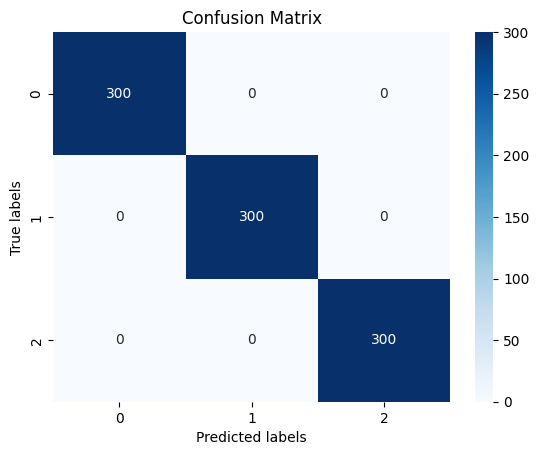

In [11]:
cm = confusion_matrix(cluster_gt, cluster_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()